In [7]:
import sys
import pandas as pd
from collections import Counter
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from horrostila import *
from widgets import *
# tai from ... import *

# Dataframe haku widgeteillä

In [8]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-05-01'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
        user="root",
        port=3306,
        passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

# Kun haku on valmis niin dataframe tallenttuu df:ään

In [9]:
df.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.530,2762,-257,37,15,787
1,1,2020-06-24 15:20:08.620,2870,-344,38,14,738
2,1,2020-06-24 15:20:09.620,2916,-344,38,14,738
3,1,2020-06-24 15:20:09.620,2894,-254,38,15,788
4,1,2020-06-24 15:20:10.110,2888,-188,38,16,838


# Dataframe suodattaminen widgeteillä

In [10]:
#display(start_date, end_date, tunnit)
display(tunnit)

SelectionRangeSlider(description='Tunnit', index=(0, 14), options=(8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

In [15]:
# Kutstutaan sort_by_widgets ja boom dataframessa on ainoastaan 11-19 tunnit
df2 = sort_by_widgets(df)
df2.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.530,2762,-257,37,15,787
1,1,2020-06-24 15:20:08.620,2870,-344,38,14,738
2,1,2020-06-24 15:20:09.620,2916,-344,38,14,738
3,1,2020-06-24 15:20:09.620,2894,-254,38,15,788
4,1,2020-06-24 15:20:10.110,2888,-188,38,16,838


# Katsotaan kuinka paljon kutakin nodea on käytetty

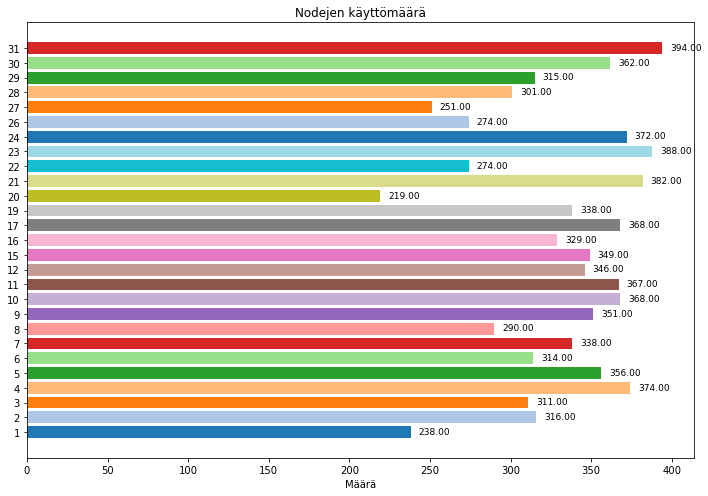

In [16]:
draw_node_amount(df2, 'node_id')

# Horrostilat dataframeen

In [6]:
df = horrostila(df)
df.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id,Horrostila
0,1,2020-08-19 08:21:14.910,2572,-752,35,10,535,False
1,1,2020-08-19 08:57:15.910,2597,-828,35,10,535,True
2,1,2020-08-19 09:24:58.910,2660,-1005,36,8,436,True
3,1,2020-08-19 09:33:14.910,2671,-925,36,9,486,True
4,1,2020-08-19 09:49:01.910,2669,-954,36,9,486,True
